## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

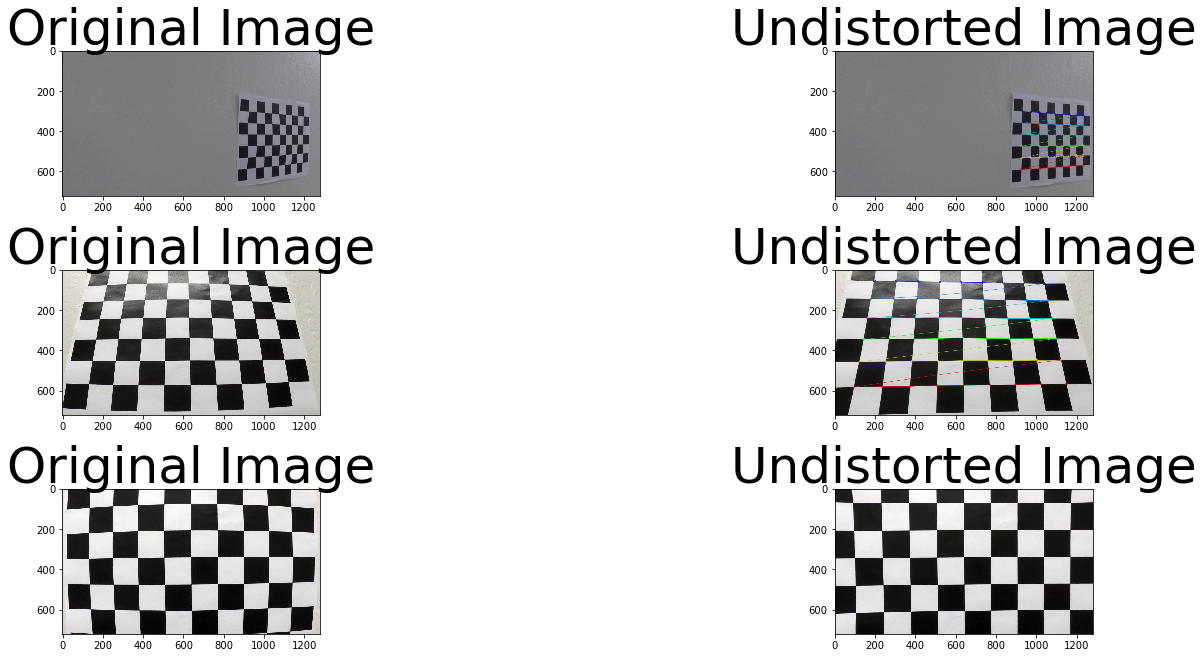

In [2]:
import math
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
files = glob.glob('camera_cal/calibration*.jpg')

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

# Step through the list and search for chessboard corners
images =[]
for fname in files:
    #read in image
    img = mpimg.imread(fname)
    # Find the chessboard corners
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        images.append(img)
        # Draw the corners
        #img = cv2.drwChessboardCorners(img, (9,6), corners, ret)
        
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24,9))
test_images = [images[0], images[15], mpimg.imread('camera_cal/test_image.jpg')]
#test_images.append(image[9])
#test_images.append(image[15])
for i, ax in enumerate(axes):
    ax1, ax2 = ax
    img = test_images[i]
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)

fig.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## And so on and so forth...

In [3]:
def grad_threshold(img, orient='x', sobel_kernel=3, grad_thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh_min = grad_thresh[0]
    thresh_max = grad_thresh[1]    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag_sobel = np.uint8(255*grad_mag/np.max(grad_mag))
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    mag_binary = np.zeros_like(scaled_mag_sobel)
    mag_binary[(scaled_mag_sobel >= thresh_min) & (scaled_mag_sobel <= thresh_max)] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    thresh_min = dir_thresh[0]
    thresh_max = dir_thresh[1]
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh_min) & (dir_sobel <= thresh_max)] = 1
    return dir_binary

In [4]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('color-shadow-example.jpg')

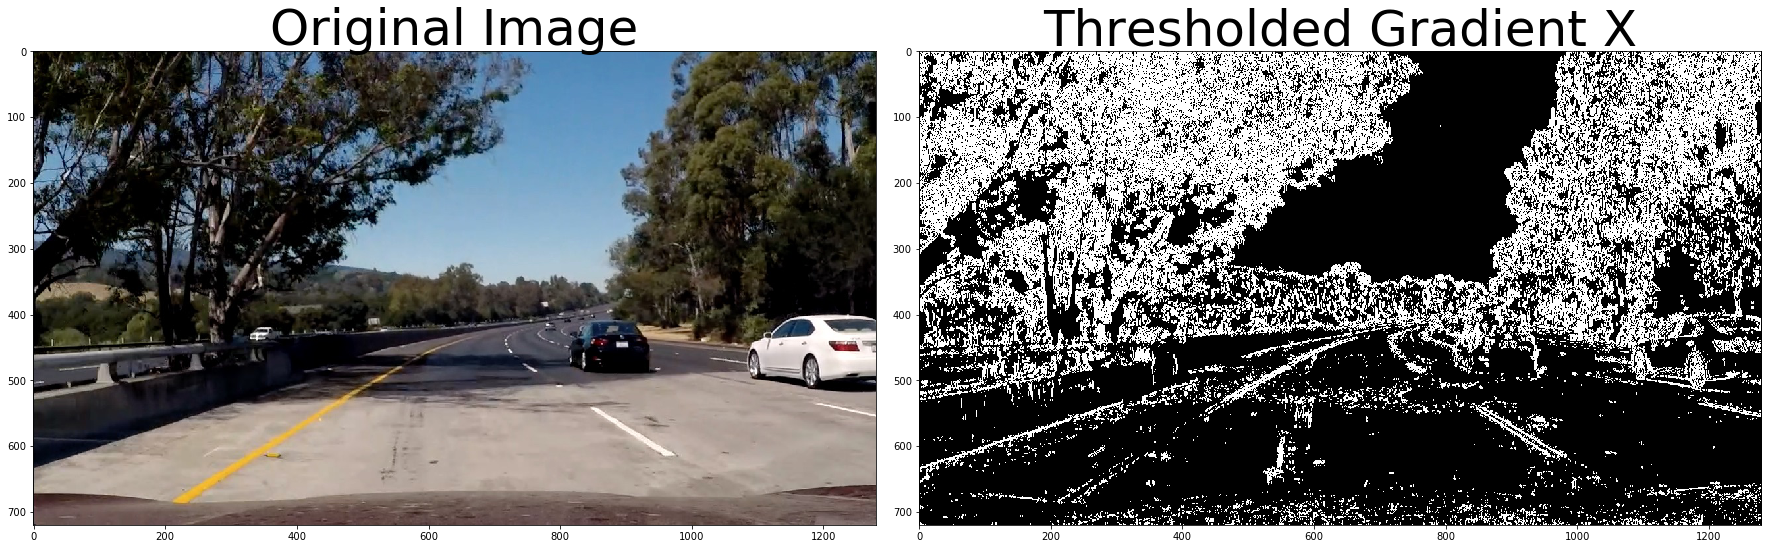

In [5]:
grad_binary = grad_threshold(image, orient='x', sobel_kernel = 7, \
                               grad_thresh=(5, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient X', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

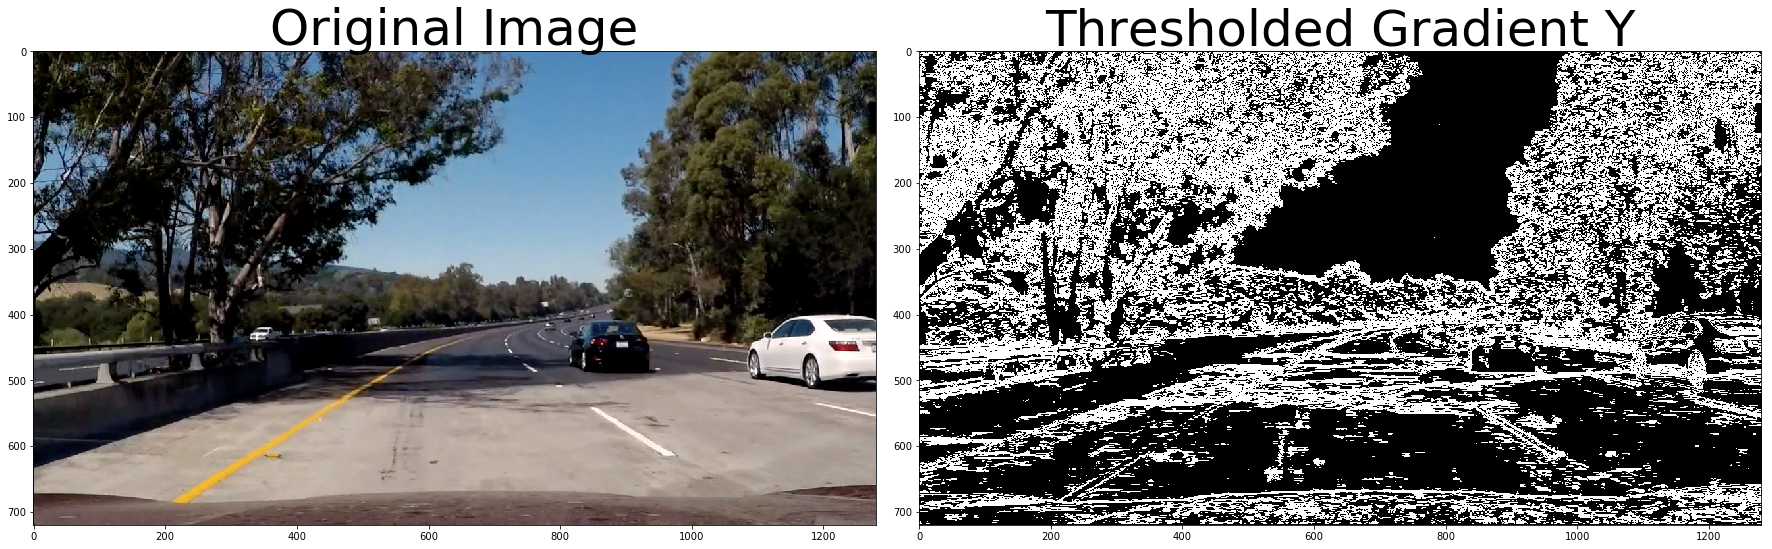

In [6]:
grad_binary = grad_threshold(image, orient='y', sobel_kernel = 7, \
                               grad_thresh=(5, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

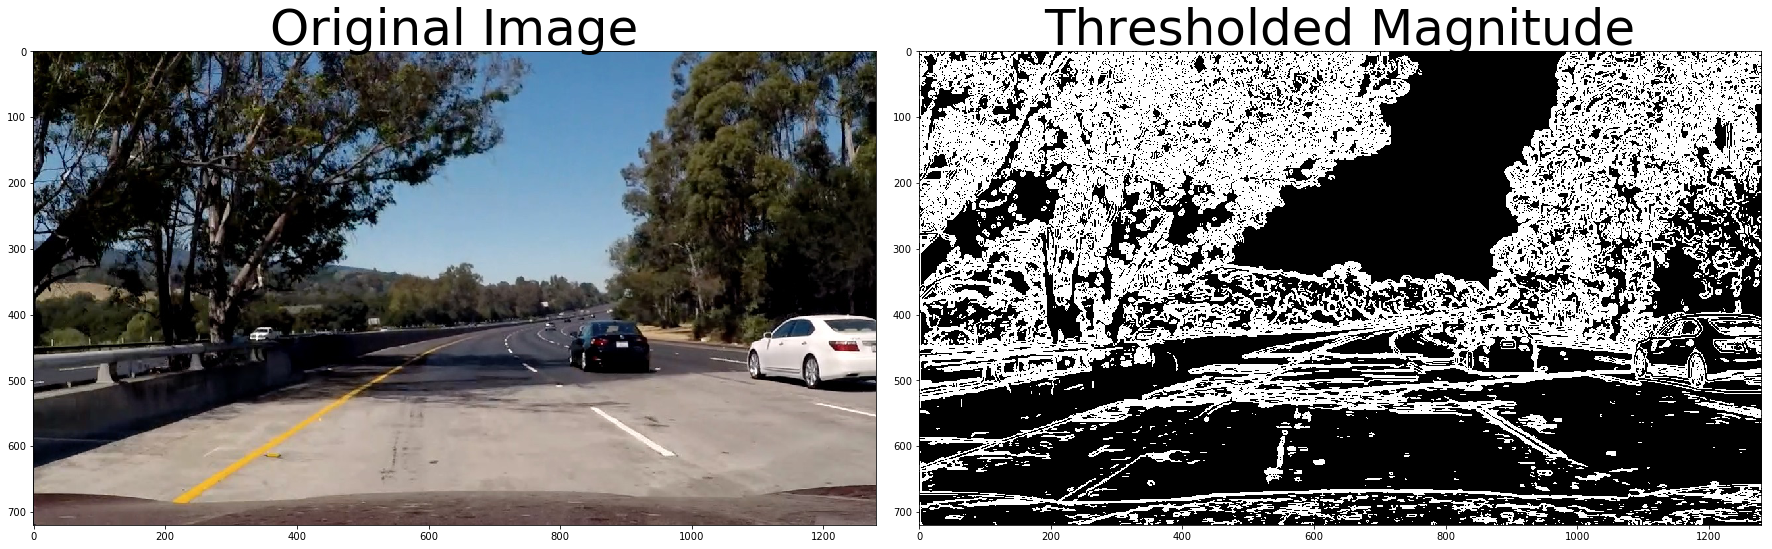

In [7]:
mag_binary = mag_threshold(image, sobel_kernel=7, mag_thresh=(10, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

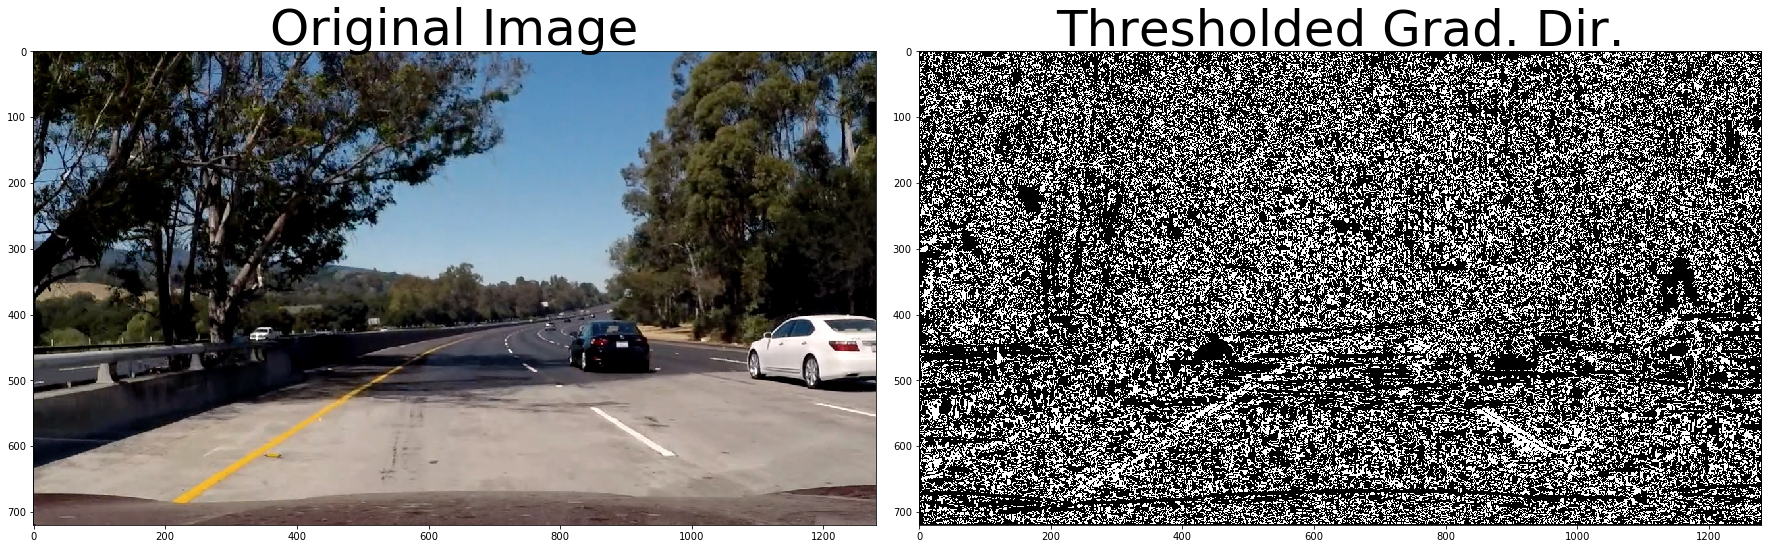

In [8]:
dir_binary = dir_threshold(image, sobel_kernel=7, dir_thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

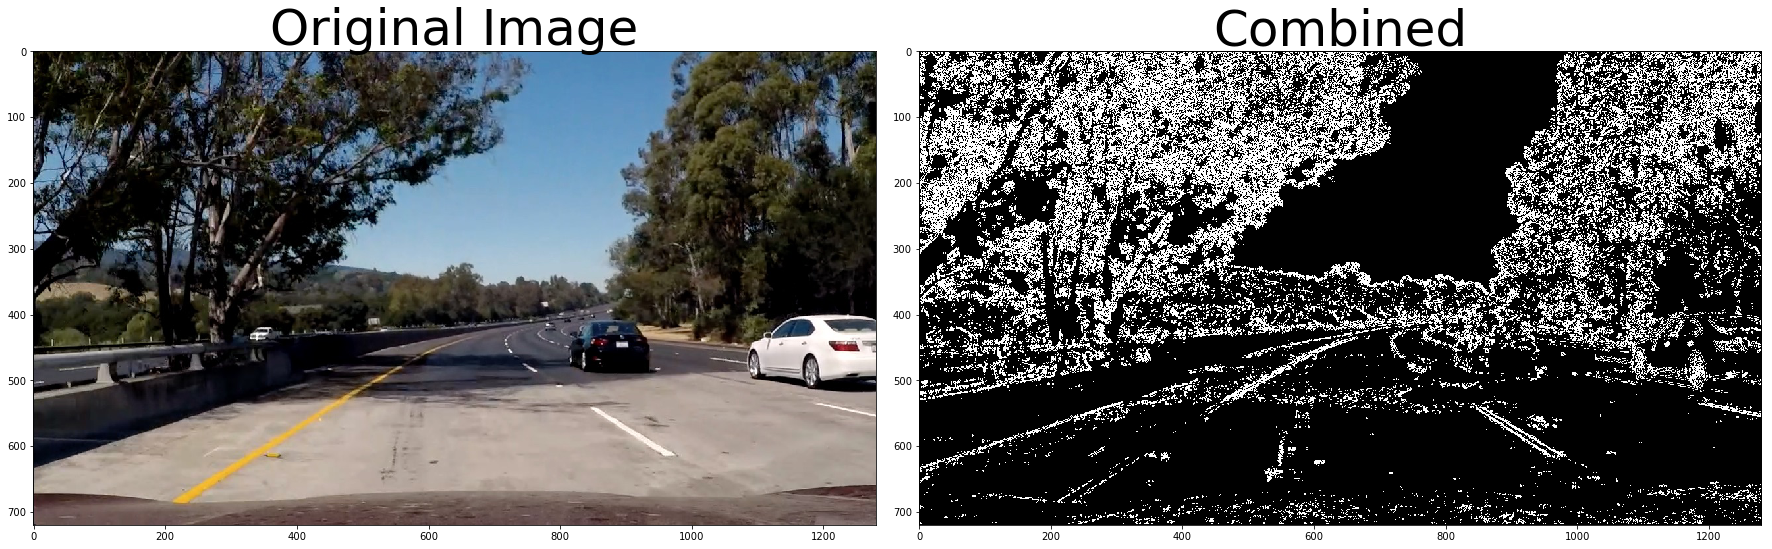

In [9]:
# Choose a Sobel kernel size
#ksize = 3 # Choose a larger odd number to smooth gradient measurements
ksize = 3

# Apply each of the thresholding functions
gradx = grad_threshold(image, orient='x', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
grady = grad_threshold(image, orient='y', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(5, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, \
                        #mag_thresh=(30, 100))
                        mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, \
                        #thresh=(0.7, 1.3))
                        dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')

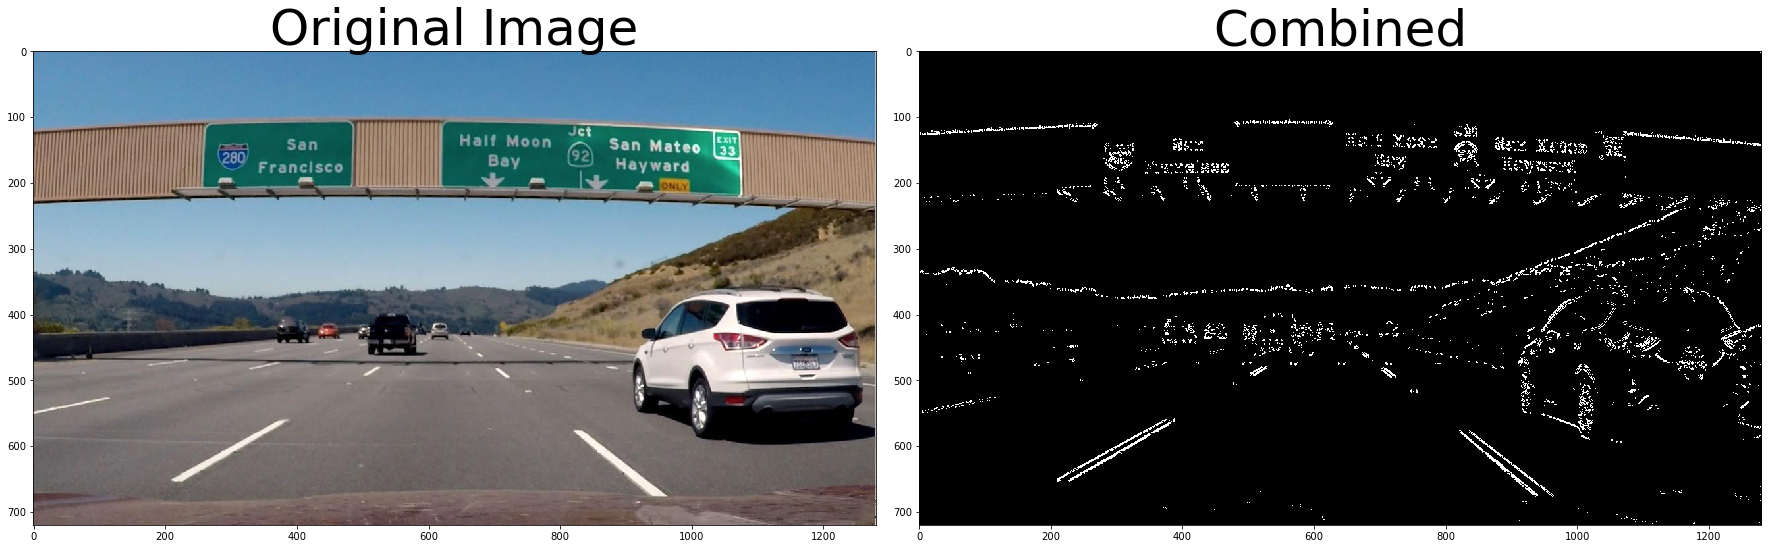

In [11]:
# Choose a Sobel kernel size
#ksize = 3 # Choose a larger odd number to smooth gradient measurements
ksize = 3

# Apply each of the thresholding functions
gradx = grad_threshold(image, orient='x', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(20, 100))
grady = grad_threshold(image, orient='y', sobel_kernel=ksize, \
                        #thresh=(5, 100))
                        grad_thresh=(20, 100))
mag_binary = mag_threshold(image, sobel_kernel=ksize, \
                        #mag_thresh=(30, 100))
                        mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, \
                        #thresh=(0.7, 1.3))
                        dir_thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

In [13]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('color-shadow-example.jpg')

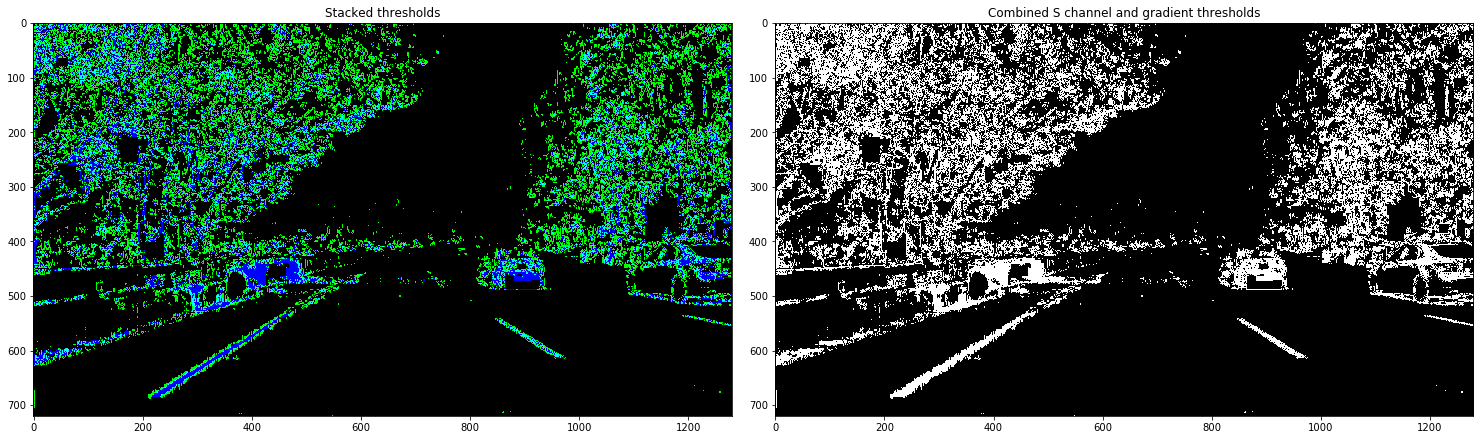

In [14]:
color_binary, combined_binary = pipeline(image)

# Plotting thresholded images
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')
#image = mpimg.imread('color-shadow-example.jpg')

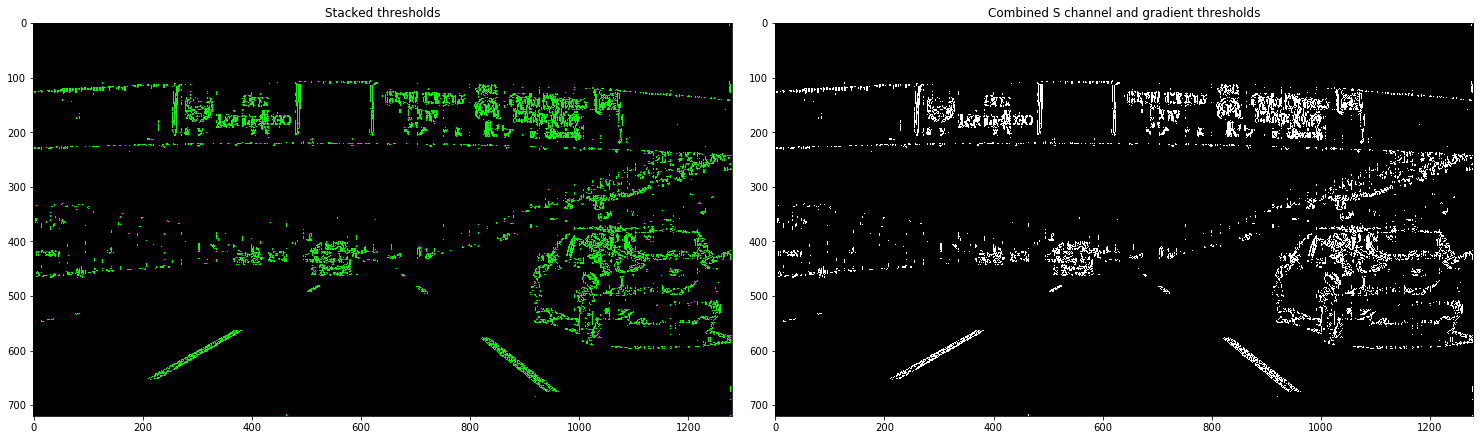

In [16]:
color_binary, combined_binary = pipeline(image)

# Plotting thresholded images
f, (ax2, ax3) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()

#ax1.imshow(image)
#ax1.set_title('Original Image', fontsize=40)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [45]:
# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')
image = mpimg.imread('color-shadow-example.jpg')

undistorted = cal_undistort(image, objpoints, imgpoints)

points = [[535,480],[770,480],[1120,690],[180,690]]
src = np.float32(points)

pts = np.array(points, np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(undistorted,[pts],True,(255,0,0), 2)

#offsetx = 450
#offsety = 0
gray = cv2.cvtColor(undistorted,cv2.COLOR_RGB2GRAY)
image_size = gray.shape[::-1]
print(image_size)
dst = np.float32([[535,0],[770,0],[770,720],[535,720]])
#dst = np.float32([[offsetx, offsety], [image_size[0]-offsetx, offsety], 
#                                     [image_size[0]-offsetx, image_size[1]-offsety], 
#                                     [offsetx, image_size[1]-offsety]])
# d) use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# e) use cv2.warpPerspective() to warp your image to a top-down view
warped = cv2.warpPerspective(undistorted, M, image_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(1280, 720)


ValueError: too many values to unpack (expected 2)